In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, precision_recall_curve, auc, balanced_accuracy_score

In [3]:
# Load Data
train_path = "/Users/zionmicwu/Desktop/assignment-4-option-1-training.csv"
test_path = "/Users/zionmicwu/Desktop/assignment-4-option-1-test.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [4]:
# The general information of datasets
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133731 entries, 0 to 133730
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      133731 non-null  object 
 1   Prod    133731 non-null  object 
 2   Quant   129252 non-null  float64
 3   Val     133215 non-null  float64
 4   Insp    133731 non-null  object 
dtypes: float64(2), object(3)
memory usage: 5.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15732 entries, 0 to 15731
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      15732 non-null  object 
 1   Prod    15732 non-null  object 
 2   Quant   15592 non-null  float64
 3   Val     15683 non-null  float64
 4   Insp    15732 non-null  object 
dtypes: float64(2), object(3)
memory usage: 614.7+ KB


In [5]:
# Summary statistics
print("Summary Statistics of Train Data:")
print(train_df.describe())
print("\n Summary Statistics of Test Data:")
print(test_df.describe())

Summary Statistics of Train Data:
              Quant           Val
count  1.292520e+05  1.332150e+05
mean   6.644151e+03  1.257081e+04
std    9.891108e+04  5.556184e+04
min    1.000000e+02  1.005000e+03
25%    1.090000e+02  1.420000e+03
50%    1.850000e+02  2.885000e+03
75%    8.870000e+02  8.730000e+03
max    1.101171e+07  3.913920e+06

 Summary Statistics of Test Data:
              Quant           Val
count  1.559200e+04  1.568300e+04
mean   1.081323e+05  6.333660e+04
std    4.565662e+06  1.758875e+05
min    1.000000e+02  1.005000e+03
25%    1.100000e+02  1.260000e+03
50%    4.460000e+02  1.259500e+04
75%    6.009500e+03  5.590750e+04
max    4.738839e+08  4.642955e+06


In [6]:
# Data Preprocessing
# Drop useless columns
train_df.drop(columns=["ID"], inplace=True)
test_df.drop(columns=["ID"], inplace=True)

In [7]:
label_encoder = LabelEncoder()
train_df["Prod"] = label_encoder.fit_transform(train_df["Prod"])
test_df["Prod"] = label_encoder.transform(test_df["Prod"])

In [8]:
# EDA
# Check for missing values
print("Missing values in training set:")
print(train_df.isnull().sum())
print("\n Missing values in test set:")
print(test_df.isnull().sum())

Missing values in training set:
Prod        0
Quant    4479
Val       516
Insp        0
dtype: int64

 Missing values in test set:
Prod       0
Quant    140
Val       49
Insp       0
dtype: int64


In [9]:
print(train_df.isnull().sum() / len(train_df) * 100)
print(test_df.isnull().sum() / len(test_df) * 100)

Prod     0.000000
Quant    3.349261
Val      0.385849
Insp     0.000000
dtype: float64
Prod     0.000000
Quant    0.889906
Val      0.311467
Insp     0.000000
dtype: float64


In [10]:
# drop missing values
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

In [11]:
# Check data types
print("Train Data Types:")
print(train_df.dtypes)
print("\n Test Data Types:")
print(test_df.dtypes)

Train Data Types:
Prod       int64
Quant    float64
Val      float64
Insp      object
dtype: object

 Test Data Types:
Prod       int64
Quant    float64
Val      float64
Insp      object
dtype: object


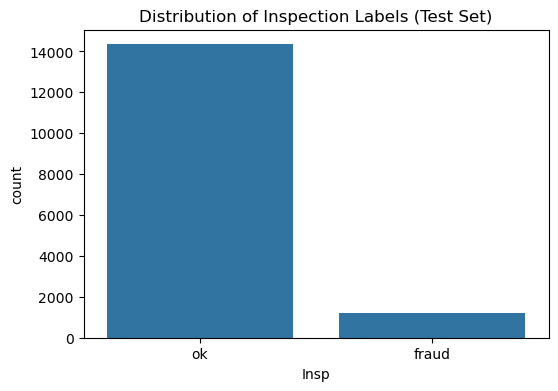

Label Distribution in Test Set:
Insp
ok       0.922874
fraud    0.077126
Name: proportion, dtype: float64


In [12]:
# Check label distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=test_df["Insp"])
plt.title("Distribution of Inspection Labels (Test Set)")
plt.show()
print("Label Distribution in Test Set:")
print(test_df["Insp"].value_counts(normalize=True))

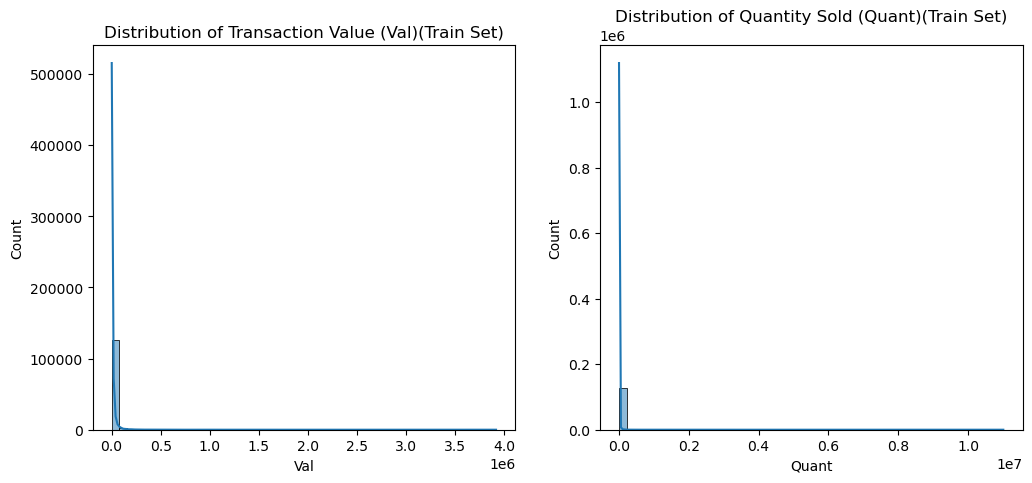

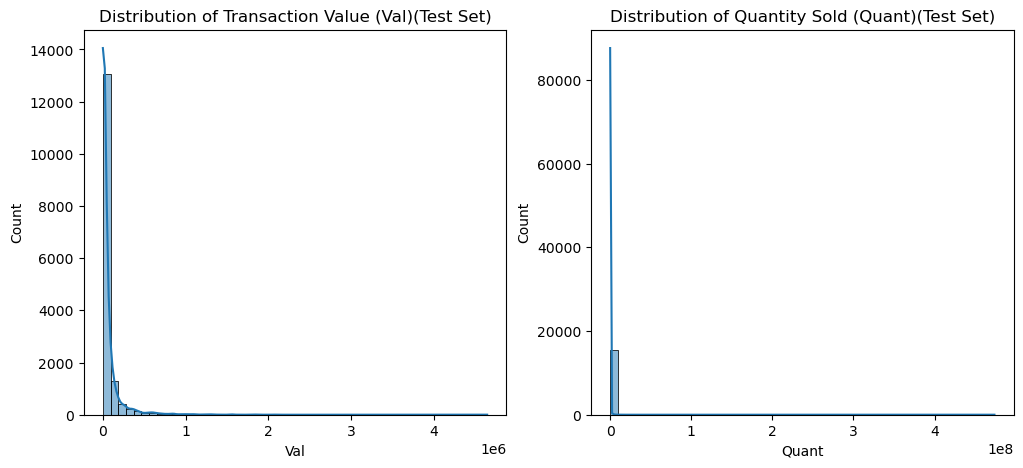

In [13]:
# Check transaction distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(train_df["Val"], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Distribution of Transaction Value (Val)(Train Set)")
sns.histplot(train_df["Quant"], bins=50, kde=True, ax=axes[1])
axes[1].set_title("Distribution of Quantity Sold (Quant)(Train Set)")
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(test_df["Val"], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Distribution of Transaction Value (Val)(Test Set)")
sns.histplot(test_df["Quant"], bins=50, kde=True, ax=axes[1])
axes[1].set_title("Distribution of Quantity Sold (Quant)(Test Set)")
plt.show()

In [14]:
# Log-transform 'Val' and 'Quant' (reduce skewness)
train_df["Log_Val"] = np.log1p(train_df["Val"])
train_df["Log_Quant"] = np.log1p(train_df["Quant"])
test_df["Log_Val"] = np.log1p(test_df["Val"])
test_df["Log_Quant"] = np.log1p(test_df["Quant"])

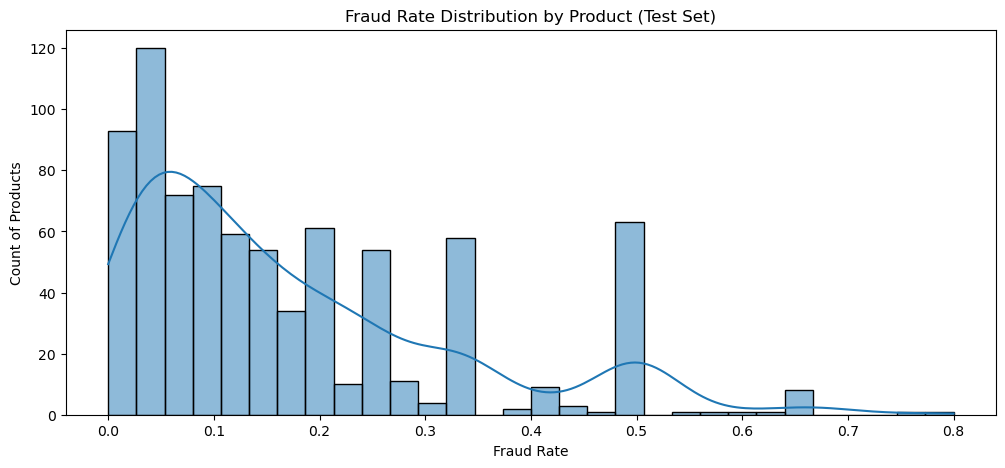

In [15]:
# Check fraud rates by product
prod_fraud_rate = test_df.groupby("Prod")["Insp"].apply(lambda x: (x == "fraud").mean())
plt.figure(figsize=(12, 5))
sns.histplot(prod_fraud_rate, bins=30, kde=True)
plt.title("Fraud Rate Distribution by Product (Test Set)")
plt.xlabel("Fraud Rate")
plt.ylabel("Count of Products")
plt.show()

In [16]:
# Define high-risk products (top 25% fraud rate)
high_risk_threshold = np.percentile(prod_fraud_rate, 75)
high_risk_prods = prod_fraud_rate[prod_fraud_rate >= high_risk_threshold].index

In [17]:
# DBSCAN + LOF
dbscan_lof_param_grid = {
    "eps": [0.1, 0.12, 0.14, 0.16, 0.18],  # DBSCAN eps
    "min_samples": [3, 5, 7, 9],  # DBSCAN min_samples
    "lof_contamination": [0.01, 0.02, 0.03, 0.04],  # LOF contamination
    "lof_threshold_percentile": [55, 60, 70, 75]  # LOF anomaly threshold
}

best_f1 = 0
best_dbscan_lof_model = None

for params in ParameterGrid(dbscan_lof_param_grid):
    dbscan = DBSCAN(eps=params["eps"], min_samples=params["min_samples"])
    test_df["DBSCAN_Cluster"] = dbscan.fit_predict(test_df[["Log_Quant", "Log_Val"]])
    test_df["DBSCAN_Anomaly"] = test_df["DBSCAN_Cluster"].apply(lambda x: "fraud" if x == -1 else "ok")

    lof = LocalOutlierFactor(n_neighbors=20, contamination=params["lof_contamination"])
    lof_scores = -lof.fit_predict(test_df[["Log_Quant", "Log_Val"]])
    test_df["LOF_Score"] = lof_scores

    lof_threshold = np.percentile(test_df["LOF_Score"], params["lof_threshold_percentile"])

    test_df["Final_Anomaly_DBSCAN_LOF"] = test_df.apply(
        lambda row: "fraud" if (row["DBSCAN_Anomaly"] == "fraud" and row["LOF_Score"] >= lof_threshold) or (row["Prod"] in high_risk_prods) else "ok",
        axis=1
    )

    report = classification_report(test_df["Insp"], test_df["Final_Anomaly_DBSCAN_LOF"], output_dict=True)
    f1_score = report["macro avg"]["f1-score"]

    if f1_score > best_f1:
        best_f1 = f1_score
        best_dbscan_lof_model = params

dbscan = DBSCAN(eps=best_dbscan_lof_model["eps"], min_samples=best_dbscan_lof_model["min_samples"])
test_df["DBSCAN_Cluster"] = dbscan.fit_predict(test_df[["Log_Quant", "Log_Val"]])
test_df["DBSCAN_Anomaly"] = test_df["DBSCAN_Cluster"].apply(lambda x: "fraud" if x == -1 else "ok")

lof = LocalOutlierFactor(n_neighbors=20, contamination=best_dbscan_lof_model["lof_contamination"])
lof_scores = -lof.fit_predict(test_df[["Log_Quant", "Log_Val"]])
test_df["LOF_Score"] = lof_scores

lof_threshold = np.percentile(test_df["LOF_Score"], best_dbscan_lof_model["lof_threshold_percentile"])

test_df["Final_Anomaly_DBSCAN_LOF"] = test_df.apply(
    lambda row: "fraud" if (row["DBSCAN_Anomaly"] == "fraud" and row["LOF_Score"] >= lof_threshold) or (row["Prod"] in high_risk_prods) else "ok",
    axis=1
)

# Calculate final classification report
final_report = classification_report(test_df["Insp"], test_df["Final_Anomaly_DBSCAN_LOF"], output_dict=True)

# Calculate Precision-Recall AUC
precision, recall, _ = precision_recall_curve(
    (test_df["Insp"] == "fraud").astype(int), 
    (test_df["Final_Anomaly_DBSCAN_LOF"] == "fraud").astype(int)
)
pr_auc = auc(recall, precision)

# Calculate Balanced Accuracy
balanced_acc = balanced_accuracy_score(
    (test_df["Insp"] == "fraud").astype(int), 
    (test_df["Final_Anomaly_DBSCAN_LOF"] == "fraud").astype(int)
)

print("Best DBSCAN + LOF Parameters:", best_dbscan_lof_model)
print(f"Best F1-score: {best_f1:.4f}")
print(f"Precision-Recall AUC: {pr_auc:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print("DBSCAN + LOF (Best Model):")
print(classification_report(test_df["Insp"], test_df["Final_Anomaly_DBSCAN_LOF"], target_names=["ok", "fraud"], digits=4))

Best DBSCAN + LOF Parameters: {'eps': 0.16, 'lof_contamination': 0.01, 'lof_threshold_percentile': 55, 'min_samples': 9}
Best F1-score: 0.7113
Precision-Recall AUC: 0.5084
Balanced Accuracy: 0.7542
DBSCAN + LOF (Best Model):
              precision    recall  f1-score   support

          ok     0.4048    0.5796    0.4767      1199
       fraud     0.9636    0.9288    0.9458     14347

    accuracy                         0.9018     15546
   macro avg     0.6842    0.7542    0.7113     15546
weighted avg     0.9205    0.9018    0.9097     15546



In [18]:
# Isolation Forest
iso_forest_param_grid = {
    "n_estimators": [300, 350, 400, 450],  # Number of trees
    "max_samples": ["auto", 0.9],  # Sample size
    "contamination": [0.06, 0.065, 0.07, 0.075]  # Anomaly contamination
}

best_f1_iforest = 0
best_iforest_model = None

for params in ParameterGrid(iso_forest_param_grid):
    iso_forest = IsolationForest(n_estimators=params["n_estimators"], max_samples=params["max_samples"],
                                 contamination=params["contamination"], random_state=42)
    
    test_df["IsoForest_Score"] = iso_forest.fit_predict(test_df[["Log_Quant", "Log_Val"]])
    
    test_df["Final_Anomaly_IsoForest"] = test_df.apply(
        lambda row: "fraud" if row["IsoForest_Score"] == -1 or row["Prod"] in high_risk_prods else "ok",
        axis=1
    )

    report = classification_report(test_df["Insp"], test_df["Final_Anomaly_IsoForest"], output_dict=True)
    f1_score = report["macro avg"]["f1-score"]

    if f1_score > best_f1_iforest:
        best_f1_iforest = f1_score
        best_iforest_model = params

iso_forest = IsolationForest(n_estimators=best_iforest_model["n_estimators"],
                             max_samples=best_iforest_model["max_samples"],
                             contamination=best_iforest_model["contamination"],
                             random_state=42)

test_df["IsoForest_Score"] = iso_forest.fit_predict(test_df[["Log_Quant", "Log_Val"]])

test_df["Final_Anomaly_IsoForest"] = test_df.apply(
    lambda row: "fraud" if row["IsoForest_Score"] == -1 or row["Prod"] in high_risk_prods else "ok",
    axis=1
)

# Calculate the final classification report
final_report_iforest = classification_report(test_df["Insp"], test_df["Final_Anomaly_IsoForest"], output_dict=True)

# Calculate Precision-Recall AUC
precision, recall, _ = precision_recall_curve(
    (test_df["Insp"] == "fraud").astype(int), 
    (test_df["Final_Anomaly_IsoForest"] == "fraud").astype(int)
)
pr_auc_iforest = auc(recall, precision)

# Calculate Balanced Accuracy
balanced_acc_iforest = balanced_accuracy_score(
    (test_df["Insp"] == "fraud").astype(int), 
    (test_df["Final_Anomaly_IsoForest"] == "fraud").astype(int)
)

print("Best Isolation Forest Parameters:", best_iforest_model)
print(f"Best F1-score: {best_f1_iforest:.4f}")
print(f"Precision-Recall AUC: {pr_auc_iforest:.4f}")
print(f"Balanced Accuracy: {balanced_acc_iforest:.4f}")
print("Isolation Forest (Best Model):")
print(classification_report(test_df["Insp"], test_df["Final_Anomaly_IsoForest"], target_names=["ok", "fraud"], digits=4))


Best Isolation Forest Parameters: {'contamination': 0.07, 'max_samples': 0.9, 'n_estimators': 400}
Best F1-score: 0.7555
Precision-Recall AUC: 0.5985
Balanced Accuracy: 0.8229
Isolation Forest (Best Model):
              precision    recall  f1-score   support

          ok     0.4586    0.7164    0.5592      1199
       fraud     0.9751    0.9293    0.9517     14347

    accuracy                         0.9129     15546
   macro avg     0.7169    0.8229    0.7555     15546
weighted avg     0.9353    0.9129    0.9214     15546



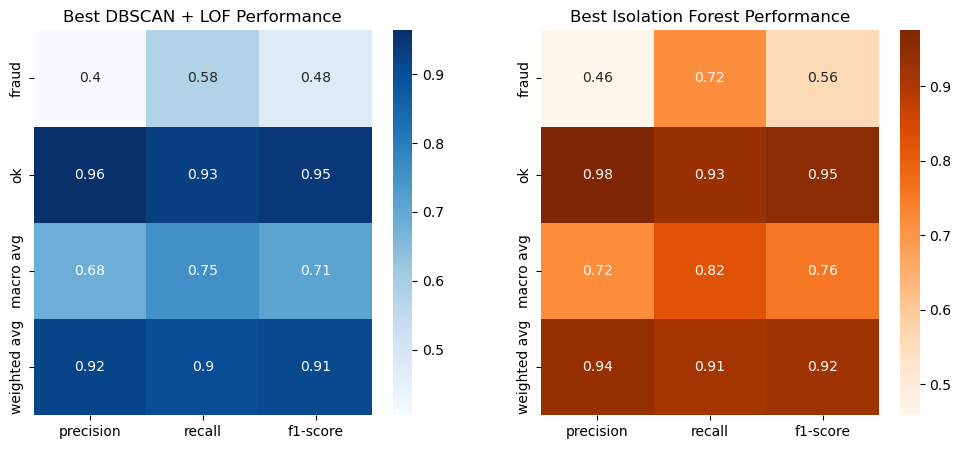

In [19]:
# Final Performance Comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# DBSCAN + LOF
best_dbscan_lof_report = classification_report(test_df["Insp"], test_df["Final_Anomaly_DBSCAN_LOF"], output_dict=True)
best_dbscan_lof_report_df = pd.DataFrame(best_dbscan_lof_report).T
best_dbscan_lof_report_df = best_dbscan_lof_report_df.drop("accuracy", axis=0)
sns.heatmap(best_dbscan_lof_report_df.iloc[:, :-1], annot=True, cmap="Blues", ax=axes[0])
axes[0].set_title("Best DBSCAN + LOF Performance")

# Isolation Forest
best_iforest_report = classification_report(test_df["Insp"], test_df["Final_Anomaly_IsoForest"], output_dict=True)
best_iforest_report_df = pd.DataFrame(best_iforest_report).T
best_iforest_report_df = best_iforest_report_df.drop("accuracy", axis=0)
sns.heatmap(best_iforest_report_df.iloc[:, :-1], annot=True, cmap="Oranges", ax=axes[1])
axes[1].set_title("Best Isolation Forest Performance")

plt.show()